In [31]:
import time
import numpy as np
import gym
from gym import spaces
from collections import defaultdict
import math
import itertools
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import plotly.graph_objects as go
import pandas as pd
import time

# Environment

In [29]:
class SmartCharging(gym.Env):
    def __init__(self, actions, cap, stuck_penalty, sequential_after_num_iterations):
        super(SmartCharging, self).__init__()
        
        self.actions = actions  
        self.cap = cap
        self.stuck_penalty = stuck_penalty
        self.sequential_after_num_iterations = sequential_after_num_iterations
        
        self.episode = 0 #Current training episode. This is used in the random start training after n episodes.
        self.old_level = 0 #Battery level at the end of the last episode.
        self.stuck = False
        self.action_space = spaces.Discrete(len(self.actions))
        self.observation_space = spaces.Dict({
            'level': spaces.Discrete(self.cap+1),
            'time': spaces.Discrete(8)
        })
        
        self.state = {
            'level': 0,
            'time': 0
        }      
        
        self.done = False
        
    def reset(self):
        self.state = {
            'level': self.old_level,
            'time': 0
        }
        self.done = False
        return self.state
    
    def reset_random(self):
        self.state = {
            'level': np.random.randint(0,100),
            'time': np.random.randint(0,7)
        }
        self.done = False
        return self.state

    def reset_episode(self): #Call this after every training!
        self.episode=0

    def step(self, action):
        loaded = self.actions.get(action) #Determines how much kWh are loaded.
        reward = 0

        if loaded + self.state['level'] > self.cap: #Loading would exceed battery capacity.
            reward -= cost_func(self.state['time'], self.cap - self.state['level']) #Only receive cost for actually loaded kWh below capcity.
            self.state['level'] = self.cap
        else:
            reward -= cost_func(self.state['time'], loaded)
            self.state['level'] += loaded

        self.state['time'] += 1

        if self.state['time'] == 8: #Terminal state. 
            consumed = power_consumed()
            if self.state['level'] - consumed >= 0: #Car had enough energy for the day.
                self.old_level = self.state['level'] - consumed
                self.stuck = False
            else: #Car gets stuck.
                self.old_level = 0
                self.stuck = True
                reward += self.stuck_penalty
                
            self.reset()
                
            self.episode += 1
            self.done = True
            
        return self.state, reward, self.done, self.stuck
    
def cost_func(t, p):
    '''
    This method returns the costs for charging
    @param t:  time
    @param p:  charging rate
    '''
    # alpha_time is the coefficient for time
    alpha_time = [1, 1, 1, 1, 1, 1, 1, 1] 
    return alpha_time[t] * math.exp(p)

def power_consumed(mu=30, sigma=5):
    '''
    This method returns power consumed by the taxi driver
    @param mu: mean
    @param sigma: standard deviation
    '''
    return int(np.random.normal(mu, sigma, 1)[0])

# Agents

## Monte Carlo 

In [3]:
class MC_Agent():
    def __init__(self, alpha, gamma, env, epsilon, epsilon_decay, epsilon_min,alpha_decay): 
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.alpha_decay = alpha_decay
        
        self.action_space_size = self.env.action_space.n 
        self.q_table = defaultdict(lambda: np.zeros(self.action_space_size))
        self.q_table_count = defaultdict(lambda: np.zeros(self.action_space_size))

    def pick_action(self, state):
        action_q_values = self.q_table.get((state['time'], state['level']), np.zeros(self.action_space_size))
        # Initialize Q-values for new state (not in table yet) with all actions to 0.  
        return self.epsilon_greedy(action_q_values)

    def epsilon_greedy(self, action_q_values):
        if np.random.rand() < self.epsilon or np.all(action_q_values==0): #Probability ε or state was never visited before.
            # Exploration: Choose a random action
            chosen_action = np.random.choice(range(self.action_space_size))
        else:
            # Exploitation: Choose the action with the highest Q-value.
            chosen_action = np.argmax(action_q_values)

        if self.epsilon > self.epsilon_min: 
            self.epsilon *= self.epsilon_decay

        return chosen_action

    def update_q_values(self, state, action, goal): #Update via Monte Carlo update rules.
        state_key = (state['time'], state['level'])
        
        if self.alpha_decay:
            self.q_table_count[state_key][action] += 1
            learning_rate = self.alpha / self.q_table_count[state_key][action] #Alpha decay. Each visit at the same State reduces the learn rate.
            self.q_table[state_key][action] += learning_rate * (goal - self.q_table[state_key][action])
        else:
            self.q_table[state_key][action] += self.alpha * (goal - self.q_table[state_key][action])
        
    def train(self, iterations,random_iter):
        for i in range(iterations):
            if i < random_iter: #Train with random initial state.
                current_state = self.env.reset_random()
            else:
                current_state = self.env.reset()
                
            episode = []
            done = False
            
            while not done: #Go through one episode until terminal state is reached.         
                action = self.pick_action(current_state)
                old_state = current_state.copy()
                current_state, reward, done, _ = self.env.step(action)
                episode.append((old_state, action, reward))

            goal = 0
            for state, action, reward in reversed(episode): #Traverse episode backwards and apply Monte Carlo rules.
                goal = reward + self.gamma * goal
                self.update_q_values(state, action, goal)
                
        self.env.reset_episode()
        return self.q_table

## SARSA

In [4]:
class SARSA_Agent():
    def __init__(self, alpha, gamma, env, epsilon, epsilon_decay, epsilon_min,alpha_decay):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.alpha_decay = alpha_decay
        
        self.action_space_size = env.action_space.n
        self.q_table = defaultdict(lambda: np.zeros(self.action_space_size))
        self.q_table_count = defaultdict(lambda: np.zeros(self.action_space_size))

    def pick_action(self, state):
        action_q_values = self.q_table.get((state['time'], state['level']), np.zeros(self.action_space_size))
        # Initialize Q-values for new state (not in table yet) with all actions to 0.  
        return self.epsilon_greedy(action_q_values)

    def epsilon_greedy(self, action_q_values):
        if np.random.rand() < self.epsilon or np.all(action_q_values==0): #Probability ε or state was never visited before.
            # Exploration: Choose a random action
            chosen_action = np.random.choice(range(self.action_space_size))
        else:
            # Exploitation: Choose the action with the highest Q-value.
            chosen_action = np.argmax(action_q_values)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return chosen_action

    def update_q_values(self, state, action, reward, next_state, next_action, done): #Update via SARSA update rules.
        state_key = (state['time'], state['level'])
        next_state_key = (next_state['time'], next_state['level'])

        td_target = reward + self.gamma * self.q_table[next_state_key][next_action] * (1 - done) #Set everything to 0 if done.
        td_error = td_target - self.q_table[state_key][action]
        
        if self.alpha_decay:
            self.q_table_count[state_key][action] += 1
            learning_rate = self.alpha / self.q_table_count[state_key][action] #Alpha decay. Each visit at the same State reduces the learn rate.
            self.q_table[state_key][action] += learning_rate * td_error
        else:
            self.q_table[state_key][action] += self.alpha * td_error
                
    def train(self, iterations,random_iter):
        for i in range(iterations):
            if i < random_iter: #Train with random initial state.
                state = self.env.reset_random()
            else:
                state = self.env.reset()
            action = self.pick_action(state)
            done = False

            while not done: #Go through one episode until terminal state is reached. 
                next_state, reward, done, _ = self.env.step(action)
                next_action = self.pick_action(next_state)

                self.update_q_values(state, action, reward, next_state, next_action, done)

                state = next_state.copy()
                action = next_action
        
        self.env.reset_episode()
        return self.q_table

## Q Learning

In [13]:
class QLearning_Agent():
    def __init__(self, alpha, gamma, env, epsilon, epsilon_decay, epsilon_min,alpha_decay):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.alpha_decay = alpha_decay
        
        self.action_space_size = env.action_space.n 
        self.q_table = defaultdict(lambda: np.zeros(self.action_space_size))
        self.q_table_count = defaultdict(lambda: np.zeros(self.action_space_size))

    def pick_action(self, state):
        action_q_values = self.q_table.get((state['time'], state['level']), np.zeros(self.action_space_size))
        # Initialize Q-values for new state (not in table yet) with all actions to 0.  
        return self.epsilon_greedy(action_q_values)

    def epsilon_greedy(self, action_q_values):
        if np.random.rand() < self.epsilon or np.all(action_q_values==0): #Probability ε or state was never visited before.
            # Exploration: Choose a random action
            chosen_action = np.random.choice(range(self.action_space_size))
        else:
            # Exploitation: Choose the action with the highest Q-value.
            chosen_action = np.argmax(action_q_values)

        if self.epsilon > self.epsilon_min: 
            self.epsilon *= self.epsilon_decay

        return chosen_action

    def update_q_values(self, state, action, reward, next_state, done): #Update via Q-learning update rules.
        state_key = (state['time'], state['level'])
        next_state_key = (next_state['time'], next_state['level'])
        
        best_next_action = np.argmax(self.q_table[next_state_key])
        td_target = reward + self.gamma * self.q_table[next_state_key][best_next_action] * (1 - done) #Set everything to 0 if done.
        td_error = td_target - self.q_table[state_key][action]
        
        if self.alpha_decay:
            self.q_table_count[state_key][action] += 1
            learning_rate = self.alpha / self.q_table_count[state_key][action] #Alpha decay. Each visit at the same State reduces the learn rate.
            self.q_table[state_key][action] += learning_rate * td_error
        else:
            self.q_table[state_key][action] += self.alpha * td_error
    def train(self, iterations,random_iter):
        for i in range(iterations):
            if i < random_iter: #Train with random initial state.
                state = self.env.reset_random()
            else:
                state = self.env.reset()
            done = False

            while not done: #Go through one episode until terminal state is reached. 
                action = self.pick_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.update_q_values(state, action, reward, next_state, done)
                state = next_state.copy()

            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            
            if i % 10000==0:
                print("Episode:",i)
        self.env.reset_episode()    
        return self.q_table

## Deep Q-Network

In [6]:
class DQN_Agent():
    def __init__(self, env, alpha, gamma, epsilon, epsilon_decay, epsilon_min, memory_size, batch_size, target_update=10):
        self.env = env
        self.state_size = 2  #time and level
        self.action_size = env.action_space.n 
        self.alpha = alpha  
        self.gamma = gamma  
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay 
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size  # Number of samples per batch for replay.
        self.target_update = target_update  # Frequency to update target network.

        # Experience replay memory
        self.memory = deque(maxlen=memory_size)

        # Main network
        self.model = self.build_model()

        # Target Q-network
        self.target_model = self.build_model()
        self.update_target_model()
        
        # Stochastic optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.alpha)

    def build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 64),  # Input layer
            nn.ReLU(), 
            nn.Linear(64, 64),  # Hidden laye
            nn.ReLU(), 
            nn.Linear(64, self.action_size)  # Output layer (number of actions)
        )
        return model

    def update_target_model(self):
        # Copy weights from main Q-network to target network.
        self.target_model.load_state_dict(self.model.state_dict())

    def pick_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Exploration: random action
        state = torch.FloatTensor(state).unsqueeze(0)  # Convert state to tensor and add batch dimension
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()  # Exploitation: choose action with highest Q-value

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        # Perform experience replay if enough samples are available.
        if len(self.memory) < self.batch_size:
            return 

        minibatch = random.sample(self.memory, self.batch_size)

        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            
            target = reward
            if not done:
                target += self.gamma * torch.max(self.target_model(next_state)).item() # Calculate target as reward + discounted max future Q-value.
            
            target_f = self.model(state).clone().detach() # Current Q-value for selected action.
            target_f[action] = target

            loss = nn.MSELoss()(self.model(state), target_f)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def generate_state_space_keys(self): # Generate all possible state keys based on the environment's observation space.
        state_space_keys = []
        for time in range(self.env.observation_space['time'].n):
            for level in range(self.env.observation_space['level'].n):
                state_space_keys.append((time, level))
        return state_space_keys

    def extract_q_table(self):
        q_table = {}
        state_space_keys = self.generate_state_space_keys()

        for state_key in state_space_keys:
            state = torch.FloatTensor(state_key).unsqueeze(0)
            with torch.no_grad():
                q_values = self.model(state).numpy().flatten()
            q_table[state_key] = q_values

        return q_table

    def train(self, episodes, random_iter):
        for e in range(episodes):
            if e < random_iter:  # Train with random initial state for exploration
                state = self.env.reset_random()
            else:
                state = self.env.reset()
            state = np.array([state['time'], state['level']])

            done = False
            total_reward = 0

            while not done:  # Go through one episode until terminal state is reached
                action = self.pick_action(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.array([next_state['time'], next_state['level']])
                total_reward += reward

                self.store_experience(state, action, reward, next_state, done)
                state = next_state
                self.replay()

            # Update target model periodically.
            if e % self.target_update == 0:
                self.update_target_model()

            print(f"Episode {e+1}/{episodes} - Reward: {total_reward}, Epsilon: {self.epsilon:.2f}")

        self.env.reset_episode()
        return self.extract_q_table()


# Evaluation methods

In [7]:
def plot_q_table_3d(q_table, cap):
    """
    Plots a 3D surface of the Q-table showing the relationship between 
    battery level, time, and Q-values.

    Parameters:
    - q_table (dict): The Q-table where keys are state tuples and values are lists/arrays of Q-values for different actions.
    - cap (int): The maximum battery level.
    """

    def get_Z(key):
        return np.average(q_table[key])

    # battery level
    X = np.arange(cap + 1)
    # time
    Y = np.arange(8)
    X_grid, Y_grid = np.meshgrid(X, Y)
    # average Q-values (policy)
    Z = np.array([get_Z(key) for key in itertools.product(Y, X)]).reshape((8, cap + 1))

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(X_grid, Y_grid, -Z, cmap='viridis')

    ax.view_init(elev=30, azim=45)

    ax.set_zlabel('Average Q-value')
    ax.set_ylabel('Time')
    ax.set_xlabel('Battery level')
    plt.tight_layout()
    plt.show()

def plot_q_table_2d(q_table):
    """
    Plots a 2D heatmap of the average Q-values over all actions for each state in the Q-table.

    Parameters:
    - q_table (dict): The Q-table where keys are state tuples and values are lists/arrays of Q-values for different actions.
    """

    levels = sorted(set(state[1] for state in q_table.keys()))
    times = sorted(set(state[0] for state in q_table.keys()))

    # Initialize a matrix with zeros
    q_matrix = np.zeros((len(levels), len(times)))

    # Fill the matrix with average Q-values
    for state_key, q_values in q_table.items():
        time, level = state_key
        if level in levels and time in times:
            level_idx = levels.index(level)
            time_idx = times.index(time)
            q_matrix[level_idx, time_idx] = np.mean(q_values)

    fig, ax = plt.subplots(figsize=(len(times), len(levels)))
    cax = ax.matshow(q_matrix, cmap='viridis')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(times)))
    ax.set_xticklabels(times)
    ax.set_yticks(np.arange(len(levels)))
    ax.set_yticklabels(levels)

    # Annotate the matrix with Q-values
    for i in range(len(levels)):
        for j in range(len(times)):
            value = q_matrix[i, j]
            ax.text(j, i, f"{value:.2f}", ha='center', va='center', color='white')

    ax.set_xlabel('Time')
    ax.set_ylabel('Battery Level')
    plt.title('Average Q-Value')
    plt.show()

def plot_greedy_policy(q_table):
    """
    Plots the greedy policy by displaying the action with the highest Q-value for each state.

    Parameters:
    - q_table (dict): The Q-table where keys are state tuples and values are lists/arrays of Q-values for different actions.
    """

    action_labels = {0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very high'}

    levels = sorted(set(state[1] for state in q_table.keys()))
    times = sorted(set(state[0] for state in q_table.keys()))

    action_matrix = np.zeros((len(levels), len(times)))

    # Populate the matrix with the best actions
    for state_key, q_values in q_table.items():
        time, level = state_key
        if level in levels and time in times:
            level_idx = levels.index(level)
            time_idx = times.index(time)
            best_action = np.argmax(q_values)
            action_matrix[level_idx, time_idx] = best_action

    fig, ax = plt.subplots(figsize=(12, 8))
    cax = ax.matshow(action_matrix, cmap='viridis', vmin=0, vmax=len(action_labels) - 1)

    cbar = fig.colorbar(cax, ticks=list(action_labels.keys()))
    cbar.ax.set_yticklabels([action_labels[i] for i in action_labels.keys()])

    xticks = np.arange(len(times))
    yticks = np.arange(len(levels))

    y_ticks_interval = max(1, len(levels) // 10)
    ax.set_yticks(yticks[::y_ticks_interval])
    ax.set_yticklabels([levels[i] for i in yticks[::y_ticks_interval]])

    x_ticks_interval = max(1, len(times) // 10)
    ax.set_xticks(xticks[::x_ticks_interval])
    ax.set_xticklabels([times[i] for i in xticks[::x_ticks_interval]])

    plt.xlabel('Time')
    plt.ylabel('Battery Level')
    plt.title('Greedy Policy (Actions)')
    ax.grid(False)
    plt.show()

def evaluate_q_table(q_table, env, num_episodes=100):
    """
    Evaluate the performance of the Q-table over a number of episodes.

    Parameters:
    - q_table (dict): The Q-table where keys are state tuples and values are lists/arrays of Q-values for different actions.
    - env (gym.Env): The environment to evaluate.
    - num_episodes (int): Number of episodes to evaluate.

    Returns:
    - float: The average reward obtained over the episodes.
    - int: The count of episodes where the agent got stuck.
    """

    total_reward = 0
    stuck_count = 0

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            state_key = (state['time'], state['level'])
            if state_key in q_table:
                action = np.argmax(q_table[state_key])
            else:
                action = 0  # No action = no loading
            
            next_state, reward, done, stuck = env.step(action)
            episode_reward += reward
            state = next_state

        total_reward += episode_reward
        if stuck:
            stuck_count += 1

    average_reward = total_reward / num_episodes
    
    return average_reward, stuck_count

def calculate_empty_q_percentage(q_table):
    """
    Calculate the percentage of Q-values in the Q-table that are empty (equal to 0).

    Parameters:
    - q_table (dict): The Q-table where keys are state tuples and values are lists/arrays of Q-values.

    Returns:
    - float: The percentage of empty Q-values in the Q-table.
    """

    total_q_values = 0
    empty_q_values = 0

    for state_key, q_values in q_table.items():
        total_q_values += len(q_values)
        empty_q_values += sum(q == 0 for q in q_values)  # Define empty as q == 0

    if total_q_values == 0:
        return 0.0

    percentage_empty = (empty_q_values / total_q_values) * 100
    return percentage_empty

def parallel_coordinates_plot(q_table, actions, max_time, max_level):
    """
    Creates a parallel coordinates plot to visualize the transitions of battery levels over time
    based on the actions taken.

    Parameters:
    - q_table (dict): The Q-table where keys are state tuples and values are lists/arrays of Q-values for different actions.
    - actions (list): List of possible actions.
    - max_time (int): Maximum time value in the environment.
    - max_level (int): Maximum battery level in the environment.
    """

    data = []

    for time in range(max_time + 1):
        for level in range(max_level + 1):
            q_values = q_table.get((time, level), [0] * len(actions))
            max_action_index = np.argmax(q_values)
            max_action_kwh = actions[max_action_index]
            data.append({
                'Time': time,
                'Battery_level': level,
                'Best_action_kwh': max_action_kwh,
                'Future_battery_level': level + max_action_kwh if level + max_action_kwh < max_level else max_level
            })
    
    df = pd.DataFrame(data)

    unique_actions = df['Best_action_kwh'].unique()
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_actions)))
    color_map = {action: f'rgb{tuple((c[:3] * 255).astype(int))}' for action, c in zip(unique_actions, colors)}

    fig = go.Figure()
    for action in unique_actions:
        action_data = df[df['Best_action_kwh'] == action]

        for i in range(len(action_data) - 1):
            x_values = [action_data.iloc[i]['Time'], action_data.iloc[i]['Time'] + 1]
            y_values = [action_data.iloc[i]['Battery_level'], action_data.iloc[i]['Future_battery_level']]

            scatters = go.Scatter(
                x=x_values,
                y=y_values,
                mode='lines+markers',
                line=dict(width=2, color=color_map.get(action, 'gray')),
                name=f'Action {action}' if i == 0 else f'Action {action}',
                showlegend=i == 0  # Only show legend for the first line of each action
            )

            fig.add_trace(scatters)

    fig.update_layout(
        title='Battery Level Transitions Over Time',
        xaxis_title='Time',
        yaxis_title='Battery Level'
    )
    fig.show()

def grid_search(agent_function, iteration_list, alpha_list, gamma_list, epsilon_decay_list, test_episodes, num_subiter):
    """
    Perform a grid search to find the optimal hyperparameters for the agent.

    Parameters:
    - agent_function (function): The function that creates the agent.
    - iteration_list (list): List of possible iteration values.
    - alpha_list (list): List of possible alpha values.
    - gamma_list (list): List of possible gamma values.
    - epsilon_decay_list (list): List of possible epsilon decay values.
    - test_episodes (int): Number of episodes to evaluate for each parameter combination.
    - num_subiter (int): Number of sub-iterations to run for averaging.

    Returns:
    - dict: A dictionary containing the average rewards for each parameter combination.
    """

    average_rewards = {}

    for iteration in iteration_list:
        for alpha in alpha_list:
            for gamma in gamma_list:
                for epsilon_decay in epsilon_decay_list:
                    agent = agent_function(alpha=alpha, gamma=gamma, env=env, epsilon=1, epsilon_decay=epsilon_decay, epsilon_min=0.01, alpha_decay=True)
                    rewards = []
                    for _ in range(num_subiter):
                        q_table = agent.train(iteration, math.floor(iteration / 5))  # ~20% random training

                        average_reward, _ = evaluate_q_table(q_table, env, num_episodes=test_episodes)
                        rewards.append(average_reward)

                    average_key = (iteration, alpha, gamma, epsilon_decay)
                    average_rewards[average_key] = np.mean(rewards)
                    print(f"Average reward for {average_key}: {average_rewards[average_key]}")
    return average_rewards

def plot_grid_search(avg_rewards):
    """
    Plots the results of a grid search as separate line plots for each hyperparameter.

    Parameters:
    - avg_rewards (dict): A dictionary containing the average rewards for each hyperparameter combination.
    """

    iteration_sums = defaultdict(float)
    iteration_counts = defaultdict(int)

    alpha_sums = defaultdict(float)
    alpha_counts = defaultdict(int)

    gamma_sums = defaultdict(float)
    gamma_counts = defaultdict(int)

    epsilon_sums = defaultdict(float)
    epsilon_counts = defaultdict(int)

    for (iteration, alpha, gamma, epsilon), reward in avg_rewards.items():
        iteration_sums[iteration] += reward
        iteration_counts[iteration] += 1

        alpha_sums[alpha] += reward
        alpha_counts[alpha] += 1

        gamma_sums[gamma] += reward
        gamma_counts[gamma] += 1

        epsilon_sums[epsilon] += reward
        epsilon_counts[epsilon] += 1

    iteration_averages = {k: iteration_sums[k] / iteration_counts[k] for k in iteration_sums}
    alpha_averages = {k: alpha_sums[k] / alpha_counts[k] for k in alpha_sums}
    gamma_averages = {k: gamma_sums[k] / gamma_counts[k] for k in gamma_sums}
    epsilon_averages = {k: epsilon_sums[k] / epsilon_counts[k] for k in epsilon_sums}

    # Plot for Iteration
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(list(iteration_averages.keys()), list(iteration_averages.values()), marker='o')
    plt.title('Average Reward by Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Average Reward')

    # Plot for Alpha
    plt.subplot(2, 2, 2)
    plt.plot(list(alpha_averages.keys()), list(alpha_averages.values()), marker='o', color='green')
    plt.title('Average Reward by Alpha')
    plt.xlabel('Alpha')
    plt.ylabel('Average Reward')

    # Plot for Gamma
    plt.subplot(2, 2, 3)
    plt.plot(list(gamma_averages.keys()), list(gamma_averages.values()), marker='o', color='red')
    plt.title('Average Reward by Gamma')
    plt.xlabel('Gamma')
    plt.ylabel('Average Reward')

    # Plot for Epsilon Decay
    plt.subplot(2, 2, 4)
    plt.plot(list(epsilon_averages.keys()), list(epsilon_averages.values()), marker='o', color='purple')
    plt.title('Average Reward by Epsilon Decay')
    plt.xlabel('Epsilon Decay')
    plt.ylabel('Average Reward')

    plt.tight_layout()
    plt.show()


# Execution

In [28]:
#actions = {i: i for i in range(23)}
actions = {0: 0, 1: 1.15, 2: 1.85, 3: 2.75, 4: 5.5}
#Tesla Model 3, SolarEdge Home EV Charger
env = SmartCharging(actions=actions, cap=60, stuck_penalty=-30000,sequential_after_num_iterations=10000)

In [34]:
t0 = time.time()
MC_Agent1 = MC_Agent(
    alpha=0.5, gamma=0.9, env=env, epsilon=1, epsilon_decay=0.9, epsilon_min=0.01,alpha_decay=False
)
MC_q_table = MC_Agent1.train(100000,20000)
t1 = time.time()
total = t1-t0
print(total)

7.374633550643921


In [20]:
SARSA_Agent1 = SARSA_Agent(
    alpha=0.1, gamma=0.95, env=env, epsilon=1, epsilon_decay=0.99, epsilon_min=0.01,alpha_decay=False
)
SARSA_q_table = SARSA_Agent1.train(100000,20000)

In [17]:
QLearning_Agent1 = QLearning_Agent(
    alpha=0.1, gamma=0.95, env=env, epsilon=1, epsilon_decay=0.999, epsilon_min=0.01,alpha_decay=False
)
QLEARN_q_table = QLearning_Agent1.train(10000000,2000000)

Episode: 0
Episode: 10000
Episode: 20000
Episode: 30000
Episode: 40000
Episode: 50000
Episode: 60000
Episode: 70000
Episode: 80000
Episode: 90000
Episode: 100000
Episode: 110000
Episode: 120000
Episode: 130000
Episode: 140000
Episode: 150000
Episode: 160000
Episode: 170000
Episode: 180000
Episode: 190000
Episode: 200000
Episode: 210000
Episode: 220000
Episode: 230000
Episode: 240000
Episode: 250000
Episode: 260000
Episode: 270000
Episode: 280000
Episode: 290000
Episode: 300000
Episode: 310000
Episode: 320000
Episode: 330000
Episode: 340000
Episode: 350000
Episode: 360000
Episode: 370000
Episode: 380000
Episode: 390000
Episode: 400000
Episode: 410000
Episode: 420000
Episode: 430000
Episode: 440000
Episode: 450000
Episode: 460000
Episode: 470000
Episode: 480000
Episode: 490000
Episode: 500000
Episode: 510000
Episode: 520000
Episode: 530000
Episode: 540000
Episode: 550000
Episode: 560000
Episode: 570000
Episode: 580000
Episode: 590000
Episode: 600000
Episode: 610000
Episode: 620000
Episod

Episode: 4890000
Episode: 4900000
Episode: 4910000
Episode: 4920000
Episode: 4930000
Episode: 4940000
Episode: 4950000
Episode: 4960000
Episode: 4970000
Episode: 4980000
Episode: 4990000
Episode: 5000000
Episode: 5010000
Episode: 5020000
Episode: 5030000
Episode: 5040000
Episode: 5050000
Episode: 5060000
Episode: 5070000
Episode: 5080000
Episode: 5090000
Episode: 5100000
Episode: 5110000
Episode: 5120000
Episode: 5130000
Episode: 5140000
Episode: 5150000
Episode: 5160000
Episode: 5170000
Episode: 5180000
Episode: 5190000
Episode: 5200000
Episode: 5210000
Episode: 5220000
Episode: 5230000
Episode: 5240000
Episode: 5250000
Episode: 5260000
Episode: 5270000
Episode: 5280000
Episode: 5290000
Episode: 5300000
Episode: 5310000
Episode: 5320000
Episode: 5330000
Episode: 5340000
Episode: 5350000
Episode: 5360000
Episode: 5370000
Episode: 5380000
Episode: 5390000
Episode: 5400000
Episode: 5410000
Episode: 5420000
Episode: 5430000
Episode: 5440000
Episode: 5450000
Episode: 5460000
Episode: 54700

Episode: 9710000
Episode: 9720000
Episode: 9730000
Episode: 9740000
Episode: 9750000
Episode: 9760000
Episode: 9770000
Episode: 9780000
Episode: 9790000
Episode: 9800000
Episode: 9810000
Episode: 9820000
Episode: 9830000
Episode: 9840000
Episode: 9850000
Episode: 9860000
Episode: 9870000
Episode: 9880000
Episode: 9890000
Episode: 9900000
Episode: 9910000
Episode: 9920000
Episode: 9930000
Episode: 9940000
Episode: 9950000
Episode: 9960000
Episode: 9970000
Episode: 9980000
Episode: 9990000


In [22]:
DQN_Agent1 = DQN_Agent(
    env=env, alpha=0.1, gamma=0.95, epsilon=1, epsilon_decay=0.99, epsilon_min=0.01, memory_size=10000, batch_size=32, target_update=10
)
DQN_q_table = DQN_Agent1.train(100,0)

Episode 1/100 - Reward: -5204.539602662723, Epsilon: 1.00
Episode 2/100 - Reward: -338.4900621751307, Epsilon: 1.00
Episode 3/100 - Reward: -559.6147684458253, Epsilon: 1.00
Episode 4/100 - Reward: -4989.481433286857, Epsilon: 0.99
Episode 5/100 - Reward: -340.7090635647422, Epsilon: 0.91
Episode 6/100 - Reward: -322.8862143222811, Epsilon: 0.84
Episode 7/100 - Reward: -9842.501058738946, Epsilon: 0.78
Episode 8/100 - Reward: -7901.726827340863, Epsilon: 0.72
Episode 9/100 - Reward: -4961.496391669202, Epsilon: 0.66
Episode 10/100 - Reward: -86.15766019873688, Epsilon: 0.61
Episode 11/100 - Reward: -1135.7486103871508, Epsilon: 0.56
Episode 12/100 - Reward: -111.30973401675305, Epsilon: 0.52
Episode 13/100 - Reward: -15002.869198330895, Epsilon: 0.48
Episode 14/100 - Reward: -256.8919031630175, Epsilon: 0.44
Episode 15/100 - Reward: -1386.4039207920473, Epsilon: 0.41
Episode 16/100 - Reward: -4925.899250640172, Epsilon: 0.38
Episode 17/100 - Reward: -115.5288498367804, Epsilon: 0.35
Ep

In [23]:
MC_avg,MC_stuck = evaluate_q_table(MC_q_table, env, num_episodes=1000)
MC_empty = calculate_empty_q_percentage(MC_q_table)
print("Monte Carlo \n Average reward: ", MC_avg ,"\n Stuck: ", MC_stuck , "\n Empty Q-values: ", MC_empty, "%")

SARSA_avg,SARSA_stuck = evaluate_q_table(SARSA_q_table, env, num_episodes=1000)
SARSA_empty = calculate_empty_q_percentage(SARSA_q_table)
print("SARSA \n Average reward: ", SARSA_avg ,"\n Stuck: ", SARSA_stuck , "\n Empty Q-values: ", SARSA_empty, "%")

QLEARN_avg,QLEARN_stuck = evaluate_q_table(QLEARN_q_table, env, num_episodes=1000)
QLEARN_empty = calculate_empty_q_percentage(QLEARN_q_table)
print("Q-Learning \n Average reward: ", QLEARN_avg ,"\n Stuck: ", QLEARN_stuck , "\n Empty Q-values: ", QLEARN_empty, "%")

DQN_avg,DQN_stuck = evaluate_q_table(DQN_q_table, env, num_episodes=1000)
DQN_empty = calculate_empty_q_percentage(DQN_q_table)
print("Deep Q-Network \n Average reward: ", DQN_avg ,"\n Stuck: ", DQN_stuck , "\n Empty Q-values: ", DQN_empty, "%")

Monte Carlo 
 Average reward:  -320.20519284120394 
 Stuck:  0 
 Empty Q-values:  0.2952029520295203 %
SARSA 
 Average reward:  -287.1743969403043 
 Stuck:  0 
 Empty Q-values:  12.5 %
Q-Learning 
 Average reward:  -117.18789647876623 
 Stuck:  0 
 Empty Q-values:  13.569682151589241 %
Deep Q-Network 
 Average reward:  -134.5570682194852 
 Stuck:  0 
 Empty Q-values:  0.0 %


In [26]:
iteration_values = [10, 20, 40, 80, 160, 300, 600, 1200, 2500, 5000, 10000, 20000, 40000, 80000]
alpha_values = [0.01,0.1,0.3,0.6,1]
gamma_values = [0.1,0.5,0.9,1]
epsilon_decay_values = [0.9,0.99,0.999]

avg_rewards = grid_search(MC_Agent,iteration_values,alpha_values,gamma_values,epsilon_decay_values,100,3)

Average reward for (10, 0.01, 0.1, 0.9): -29508.107051506533
Average reward for (10, 0.01, 0.1, 0.99): -29508.0
Average reward for (10, 0.01, 0.1, 0.999): -29208.034816890704
Average reward for (10, 0.01, 0.5, 0.9): -29208.130262766997
Average reward for (10, 0.01, 0.5, 0.99): -29508.02321126047
Average reward for (10, 0.01, 0.5, 0.999): -29408.02321126047
Average reward for (10, 0.01, 0.9, 0.9): -29408.02321126047
Average reward for (10, 0.01, 0.9, 0.99): -29108.011605630236
Average reward for (10, 0.01, 0.9, 0.999): -29308.02321126047
Average reward for (10, 0.01, 1, 0.9): -29208.153474027466
Average reward for (10, 0.01, 1, 0.99): -29408.011605630236
Average reward for (10, 0.01, 1, 0.999): -29408.011605630236
Average reward for (10, 0.1, 0.1, 0.9): -29308.176685287937
Average reward for (10, 0.1, 0.1, 0.99): -29208.034816890704
Average reward for (10, 0.1, 0.1, 0.999): -29408.034816890704
Average reward for (10, 0.1, 0.5, 0.9): -29808.0
Average reward for (10, 0.1, 0.5, 0.99): -292

Average reward for (40, 0.3, 0.5, 0.9): -29111.758879158162
Average reward for (40, 0.3, 0.5, 0.99): -28083.56202942264
Average reward for (40, 0.3, 0.5, 0.999): -29409.061226344642
Average reward for (40, 0.3, 0.9, 0.9): -29408.344365780056
Average reward for (40, 0.3, 0.9, 0.99): -28948.04349223016
Average reward for (40, 0.3, 0.9, 0.999): -29208.034816890704
Average reward for (40, 0.3, 1, 0.9): -27878.357172849326
Average reward for (40, 0.3, 1, 0.99): -29110.05021807346
Average reward for (40, 0.3, 1, 0.999): -29308.260525534
Average reward for (40, 0.6, 0.1, 0.9): -29209.957373031586
Average reward for (40, 0.6, 0.1, 0.99): -29208.28373679447
Average reward for (40, 0.6, 0.1, 0.999): -29308.011605630236
Average reward for (40, 0.6, 0.5, 0.9): -28760.078215008365
Average reward for (40, 0.6, 0.5, 0.99): -27744.976520547294
Average reward for (40, 0.6, 0.5, 0.999): -29408.11865713676
Average reward for (40, 0.6, 0.9, 0.9): -29142.466673511633
Average reward for (40, 0.6, 0.9, 0.99)

Average reward for (160, 0.6, 1, 0.999): -24957.778865580753
Average reward for (160, 1, 0.1, 0.9): -20441.57246141371
Average reward for (160, 1, 0.1, 0.99): -25455.114556809887
Average reward for (160, 1, 0.1, 0.999): -19158.722985200802
Average reward for (160, 1, 0.5, 0.9): -16097.463087782307
Average reward for (160, 1, 0.5, 0.99): -13527.64420871462
Average reward for (160, 1, 0.5, 0.999): -29110.597081236338
Average reward for (160, 1, 0.9, 0.9): -20084.000554602633
Average reward for (160, 1, 0.9, 0.99): -14326.42683917079
Average reward for (160, 1, 0.9, 0.999): -15172.585353379634
Average reward for (160, 1, 1, 0.9): -16506.879462309487
Average reward for (160, 1, 1, 0.99): -14316.896823783942
Average reward for (160, 1, 1, 0.999): -26158.197568654665
Average reward for (300, 0.01, 0.1, 0.9): -22478.166924192712
Average reward for (300, 0.01, 0.1, 0.99): -25320.616657061797
Average reward for (300, 0.01, 0.1, 0.999): -25459.218362797274
Average reward for (300, 0.01, 0.5, 0.9

Average reward for (1200, 0.01, 0.5, 0.9): -513.6546374933935
Average reward for (1200, 0.01, 0.5, 0.99): -1097.6544277426676
Average reward for (1200, 0.01, 0.5, 0.999): -484.3914642010227
Average reward for (1200, 0.01, 0.9, 0.9): -644.3172645428091
Average reward for (1200, 0.01, 0.9, 0.99): -602.467603519906
Average reward for (1200, 0.01, 0.9, 0.999): -919.8030141469195
Average reward for (1200, 0.01, 1, 0.9): -1688.6769996769374
Average reward for (1200, 0.01, 1, 0.99): -520.6232408536738
Average reward for (1200, 0.01, 1, 0.999): -580.2382427730361
Average reward for (1200, 0.1, 0.1, 0.9): -13105.883646620248
Average reward for (1200, 0.1, 0.1, 0.99): -4417.170917682341
Average reward for (1200, 0.1, 0.1, 0.999): -5008.102919964754
Average reward for (1200, 0.1, 0.5, 0.9): -7305.3768535475365
Average reward for (1200, 0.1, 0.5, 0.99): -7975.233051461273
Average reward for (1200, 0.1, 0.5, 0.999): -742.322849574765
Average reward for (1200, 0.1, 0.9, 0.9): -5803.148039686736
Aver

Average reward for (5000, 0.1, 0.5, 0.99): -353.6171434294629
Average reward for (5000, 0.1, 0.5, 0.999): -163.5283055865727
Average reward for (5000, 0.1, 0.9, 0.9): -166.71821323083273
Average reward for (5000, 0.1, 0.9, 0.99): -281.98203820585974
Average reward for (5000, 0.1, 0.9, 0.999): -197.79838710443588
Average reward for (5000, 0.1, 1, 0.9): -443.691820440977
Average reward for (5000, 0.1, 1, 0.99): -200.2008808537695
Average reward for (5000, 0.1, 1, 0.999): -215.99691443651383
Average reward for (5000, 0.3, 0.1, 0.9): -3504.2384177237636
Average reward for (5000, 0.3, 0.1, 0.99): -2554.661328455342
Average reward for (5000, 0.3, 0.1, 0.999): -938.5590809312238
Average reward for (5000, 0.3, 0.5, 0.9): -279.4916579579877
Average reward for (5000, 0.3, 0.5, 0.99): -158.98130330384546
Average reward for (5000, 0.3, 0.5, 0.999): -369.872732788396
Average reward for (5000, 0.3, 0.9, 0.9): -339.43526726757347
Average reward for (5000, 0.3, 0.9, 0.99): -342.9520536230547
Average r

Average reward for (20000, 0.3, 0.5, 0.99): -272.96348263530723
Average reward for (20000, 0.3, 0.5, 0.999): -273.3275193913856
Average reward for (20000, 0.3, 0.9, 0.9): -136.78279759446983
Average reward for (20000, 0.3, 0.9, 0.99): -150.63205007761306
Average reward for (20000, 0.3, 0.9, 0.999): -157.25208901160372
Average reward for (20000, 0.3, 1, 0.9): -165.20397480844554
Average reward for (20000, 0.3, 1, 0.99): -457.8555782534034
Average reward for (20000, 0.3, 1, 0.999): -191.96510201264059
Average reward for (20000, 0.6, 0.1, 0.9): -6212.713429298215
Average reward for (20000, 0.6, 0.1, 0.99): -1914.4091348443787
Average reward for (20000, 0.6, 0.1, 0.999): -4575.108860106935
Average reward for (20000, 0.6, 0.5, 0.9): -144.2688001438714
Average reward for (20000, 0.6, 0.5, 0.99): -377.6504289042811
Average reward for (20000, 0.6, 0.5, 0.999): -266.0778951958758
Average reward for (20000, 0.6, 0.9, 0.9): -175.3827428843812
Average reward for (20000, 0.6, 0.9, 0.99): -287.92829

Average reward for (80000, 0.6, 0.5, 0.9): -425.89060729556826
Average reward for (80000, 0.6, 0.5, 0.99): -182.18390114578835
Average reward for (80000, 0.6, 0.5, 0.999): -273.4320155744262
Average reward for (80000, 0.6, 0.9, 0.9): -365.5877247051474
Average reward for (80000, 0.6, 0.9, 0.99): -151.0273811759197
Average reward for (80000, 0.6, 0.9, 0.999): -257.52614105642715
Average reward for (80000, 0.6, 1, 0.9): -229.36776765182535
Average reward for (80000, 0.6, 1, 0.99): -157.48271205257245
Average reward for (80000, 0.6, 1, 0.999): -140.95864038762463
Average reward for (80000, 1, 0.1, 0.9): -4770.655755901326
Average reward for (80000, 1, 0.1, 0.99): -4543.784503695796
Average reward for (80000, 1, 0.1, 0.999): -6205.593237546694
Average reward for (80000, 1, 0.5, 0.9): -370.13610444743375
Average reward for (80000, 1, 0.5, 0.99): -161.7718771271913
Average reward for (80000, 1, 0.5, 0.999): -174.5435727944238
Average reward for (80000, 1, 0.9, 0.9): -238.4427530519977
Averag

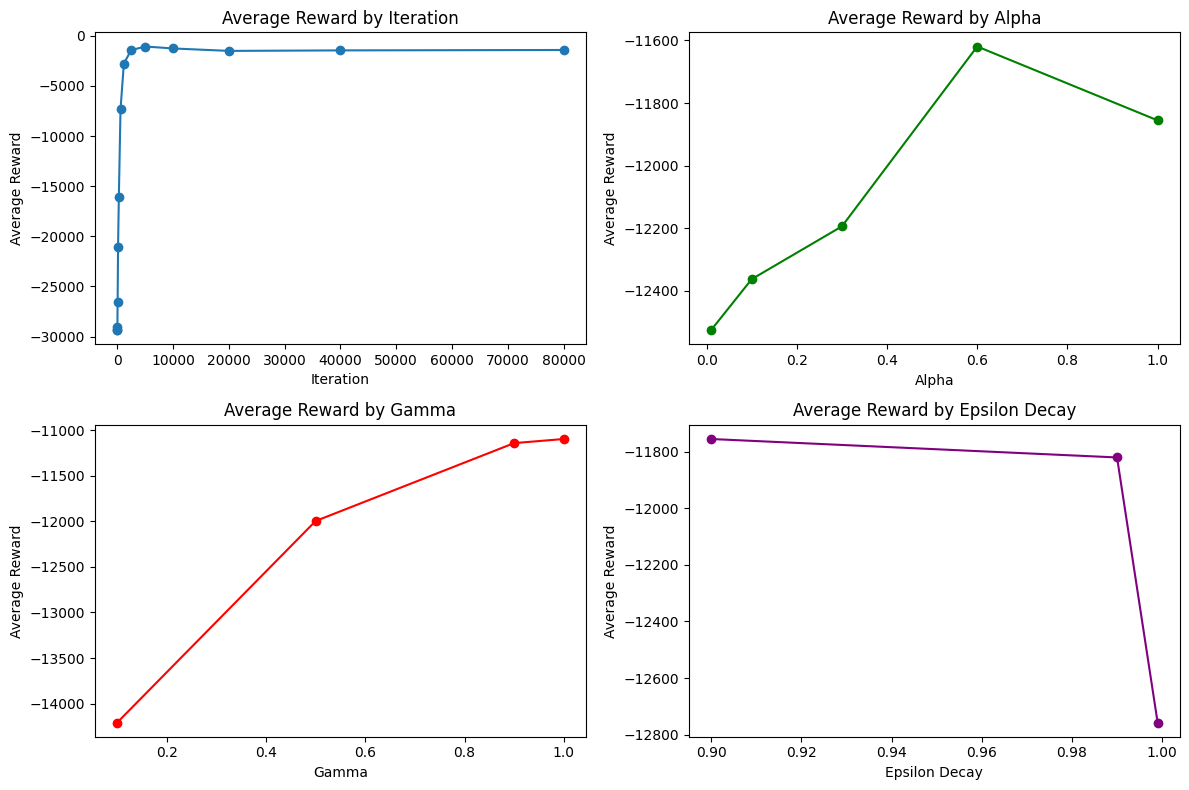

In [27]:
plot_grid_search(avg_rewards)

Note: Performance is lowest around the time when the iterations end when epsilon hits epsilon_min.

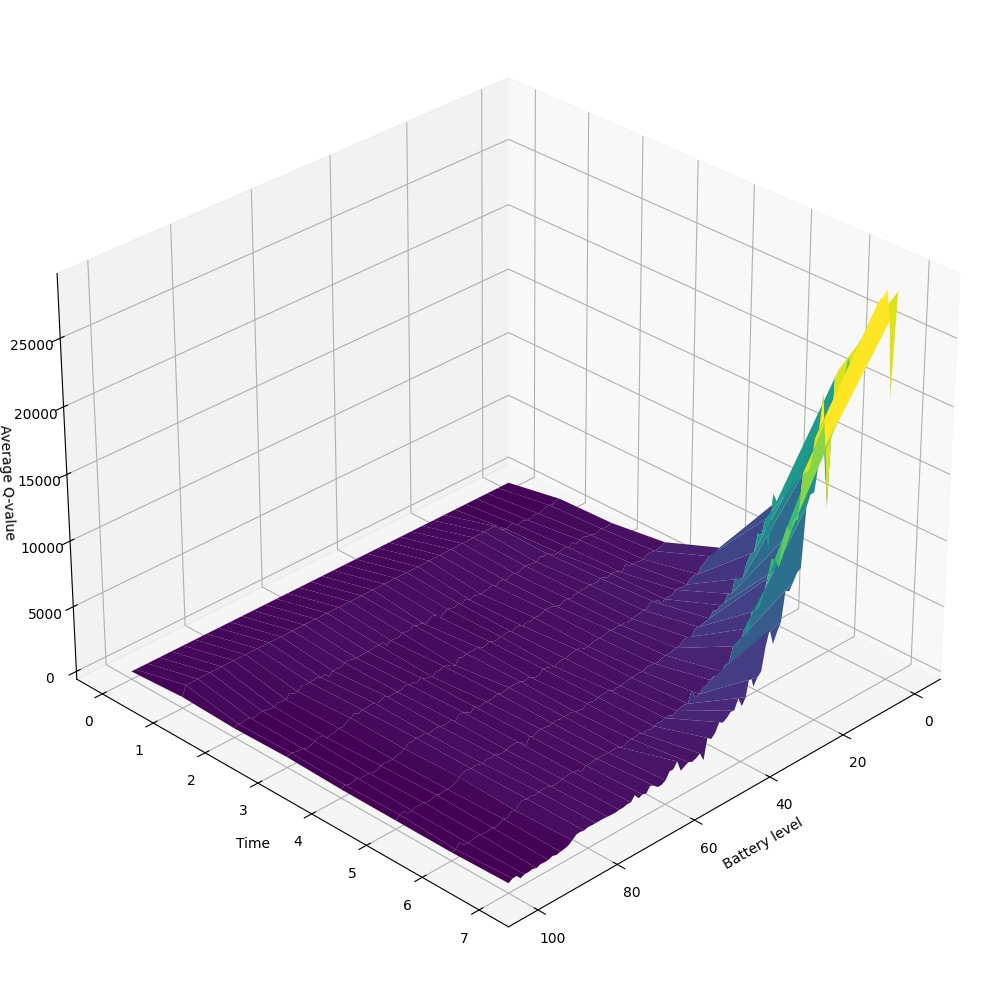

In [15]:
plot_q_table_3d(QLEARN_q_table,env.cap)

In [18]:
max_time = 7
max_level = env.cap
actions = {0: 0, 1: 3, 2: 7, 3: 11, 4: 17}
parallel_coordinates_plot(QLEARN_q_table, actions, max_time, max_level)

Eigentlich müsste man betrachten, dass es Sinn macht langsam zu laden immer wenn man unter cap ist weil das auto ja am nächsten Tag eh wieder benutzt wird